3. Set up iterative synthetic training (each cf should see slightly different training data, though might not be necessary due to dropout)
4. Try learning the whole cost fxn, or adjusting weights with vel cost

In [1]:
import numpy as np
from models import CostFunction
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import utils
import constants as c
import planners
from planners import feature_height, feature_orientation
import itertools
from keras import backend as K
import openravepy as orpy
import json
%matplotlib inline

Using TensorFlow backend.


In [2]:
env, robot = utils.setup()

In [5]:
robot.SetActiveDOFValues(c.configs[5])

In [ ]:
approved = []
for i, (start, goal) in enumerate(c.start_goal_pairs):
    robot.SetActiveDOFValues(start)
    with env:
        res = planners.trajopt_simple_plan(env, robot, goal)
        traj = utils.waypoints_to_traj(env, robot, res.GetTraj(), 1, None)
    robot.ExecuteTrajectory(traj)
    ans = raw_input()
    if ans == 'yes':
        approved.append(i)
        print('Approved')

In [3]:
with open('./data/world_space_trajs.pkl', 'rb') as f:
    data = pickle.load(f)
    with env:
        wf = np.stack([utils.world_space_featurizer(robot, wps) for wps in data])
    data = np.concatenate([data, wf], axis=-1)
#data_times = np.ones((data.shape[0], 10))
#data = np.insert(data, 7, data_times, axis=-1)

In [4]:
wps = data[0][:,:7]

In [4]:
traj = utils.waypoints_to_traj(env, robot, wps, 0.5, None)

In [8]:
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [4]:
with env:
    default_traj = planners.trajopt_simple_plan(env, robot, c.configs[1])
    traj = utils.waypoints_to_traj(env, robot, default_traj.GetTraj(), 0.5, None)

In [5]:
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [4]:
cf = CostFunction(robot, num_dofs=21) #use_total_duration=True)
#cf.load_model('./data/saves/sad_weight_time.cpkt')
custom_cost = {'NN': planners.get_trajopt_cost(cf)}

In [6]:
robot.SetActiveDOFValues(c.configs[0])

In [7]:
def cost_height(x):
    val = 1 * feature_height(robot, x)
    return val
def cost_orientation(x):
    return .05 * feature_orientation(robot, x)
def time_cost(x):
    time = np.sum(x[:,7])
    desired_time = 10
    return (time - desired_time)**2

synthetic_costs = {
    'height': cost_height,
    'orientation': cost_orientation
}

def synthetic_cost(x):
    traj = x[:,:7]
    with env:
        traj_cost = utils.evaluate_costs(robot, traj, synthetic_costs)
    traj_cost #+= time_cost(x)
    return traj_cost
synthetic_label = utils.synthetic_label_func(synthetic_cost)

In [8]:
with env:
    synthetic = planners.trajopt_simple_plan(env, robot, c.configs[1], custom_costs=synthetic_costs).GetTraj()
    synthetic_traj = utils.waypoints_to_traj(env, robot, synthetic, 10, None)

In [9]:
def train(tq, epochs=5):
    for i in range(epochs * len(tq)):
        (xA, timeA), (xB, timeB), label = tq.sample()
        tA, tB = xA[:,7:], xB[:,7:]
        cf.train(tA[None], tB[None], [int(label)], total_time=(timeA, timeB))

In [10]:
data_q = utils.TrainingQueue(maxsize=100)
for i in range(data.shape[0] / 2):
    data_q.add(data[i])
training_q = utils.TrainingQueue(maxsize=10000)
time_q = utils.TrainingQueue(maxsize=3000)

In [11]:
for i in range(10):
    #time_ratio = 0.5 if i > 5 else 0
    time_ratio = 0.
    utils.get_labels(cf, data_q, training_q, synthetic_label, num_samples=40, time_ratio=time_ratio, adaptive_timing=False)
    #train(training_q, epochs=15)
    #train(time_q, epochs=10)
    #with env:
    #    results = planners.trajopt_multi_plan(env, robot, c.configs[1], custom_traj_costs=custom_cost, num_inits=20)
    #    features = [np.concatenate([res.GetTraj(), utils.world_space_featurizer(robot, res.GetTraj())], axis=1) for res in results]
    #data_q.extend(features)

In [12]:
for i in range(1):
    utils.get_labels(cf, data_q, training_q, synthetic_label, num_samples=100, time_ratio=1, adaptive_timing=False)
    train(training_q, epochs=20)

In [17]:
a = training_q.sample()

In [13]:
true_costs = []
test_trajs = []
with env:
    for i in range(200):
        idx = np.random.choice(data.shape[0] / 2) + (data.shape[0] / 2)
        test_trajs.append(data[idx][:,7:])
        true_costs.append(synthetic_cost(data[idx]))
true_costs = np.array(true_costs)
test_trajs = np.stack(test_trajs)

In [14]:
cf.corrcoef(test_trajs, true_costs)

0.12288076174563491

In [23]:
robot.SetActiveDOFValues(c.configs[2])

In [21]:
with env:
    results = planners.trajopt_simple_plan(env, robot, c.configs[1], custom_traj_costs=custom_cost)

In [22]:
with env:
    traj = utils.waypoints_to_traj(env, robot, results.GetTraj(), 10, None)

In [ ]:
robot.ExecuteTrajectory(traj)

In [24]:
with env:
    results = planners.trajopt_multi_plan(env, robot, c.configs[3], custom_traj_costs=custom_cost, num_inits=20)
costs = []
for res in results:
    with env:
        wf = utils.world_space_featurizer(robot, res.GetTraj())
    costs.append(cf.cost_traj(wf))
opt_res = results[np.argmin(costs)]
with env:
    traj = utils.waypoints_to_traj(env, robot, opt_res.GetTraj(), 10, None)

In [25]:
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

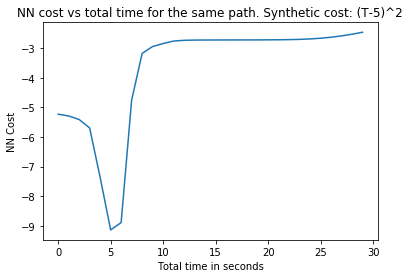

In [20]:
costs = cf.naive_time_opt(opt_res.GetTraj(), return_costs=True)
plt.title('NN cost vs total time for the same path. Synthetic cost: (T-5)^2')
plt.xlabel('Total time in seconds')
plt.ylabel('NN Cost')
plt.plot(costs)

In [14]:
with env:
    results = planners.trajopt_multi_plan(env, robot, c.configs[1], custom_traj_costs=custom_cost, num_inits=20)

In [15]:
for res in results:
    robot.SetActiveDOFValues(c.configs[0])
    with env:
        waypoints = res.GetTraj()
        traj = utils.waypoints_to_traj(env, robot, waypoints, 10, None)
    robot.ExecuteTrajectory(traj)

## Different configs

In [19]:
robot.SetActiveDOFValues(c.configs[3])

In [22]:
with env:
    res = planners.trajopt_simple_plan(env, robot, c.configs[2])
    waypoints = res.GetTraj()
    traj = utils.waypoints_to_traj(env, robot, waypoints, 10, None)

In [25]:
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

## Time optimization

In [26]:
world_features = utils.world_space_featurizer(robot, waypoints)

In [27]:
optim = np.concatenate([1.5 * np.ones(10)[:,None], world_features], axis=1)

In [28]:
time_deltas = cf.optimize_timing(world_features)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  Objective function value: 0.118207
  Number of iterations: 15
  Number of functions evaluations: 16


In [29]:
time_deltas

array([ 0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.48687705,
        0.1       ,  5.01334286,  2.05080271,  1.74623322,  0.1       ], dtype=float32)

In [30]:
cf.cost_traj(optim)

array(0.12200494855642319, dtype=float32)